# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 5
## Identifying Performance Tweaks

Using this notebook to try and identify some things specific to this dataset/our trained models that might need to be dealt with in order to get better performing models.

The nature of the dataset has me feeling that generic augmentations may be doing some harm with some good and being more intentional in what augmentations are performed may improve the ratio of benefit/harm.

The nature of validation loss halting improvement while accuracy continues to improve so early in the average training process (regardless of model) is something I have felt uncomfortable with.  Having this happen after some training would not be as surprising but in a few iterations is something I want to try and improve (or at least hopefully understand).

So far, we have come within a couple of percentage points away from the leader spot without any error analysis of models (crazy).  We should do this to try and see what types of errors are being made and see if improvement can occur.

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [4]:
import timm
from fastai.vision.all import *
set_seed(42)

# path.ls()

In [5]:
trn_path = path/'corn'/'train'
# trn_path.ls()

In [6]:
tst_path = path/'corn'/'test'
# tst_path.ls()

Grab csv lists

In [7]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
train = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
test = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

In [8]:
print(train.head())

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


In [9]:
train['label'].value_counts()

pure          5837
broken        4554
discolored    2504
silkcut       1427
Name: label, dtype: int64

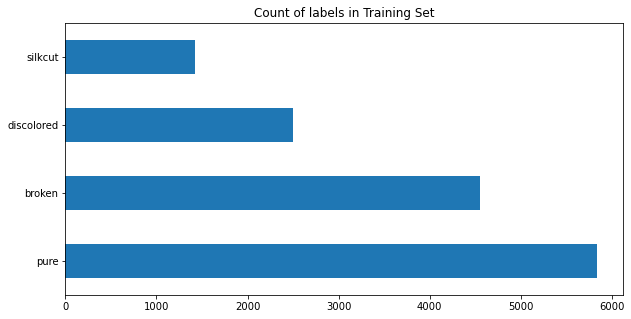

In [10]:
train['label'].value_counts() \
    .plot(kind='barh',
          figsize=(10,5),
          title='Count of labels in Training Set')
plt.show()

## Looking at the data

In [11]:
files = get_image_files(trn_path)

(140, 140)


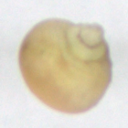

In [12]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

## Check image sizes
Check all the image sizes.  This is faster in parallel.  Using fastcore's `parallel` for this:

In [13]:
print (f"Total number of train images: {len(files)}")

Total number of train images: 14322


In [14]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
# AMD Ryzen 9 5900X 12-Cores / 24-Threads
sizes = parallel(f, files, n_workers=24)
pd.Series(sizes).value_counts()

(132, 132)    187
(140, 136)    187
(136, 132)    168
(136, 136)    166
(128, 132)    165
             ... 
(136, 121)      1
(140, 104)      1
(208, 168)      1
(104, 180)      1
(204, 164)      1
Length: 784, dtype: int64

Get image widths and heights and find the max of both for padding purposes.

Note size elements are in the structure (width, height) according to [here](https://note.nkmk.me/en/python-opencv-pillow-image-size/).

In [15]:
def get_widths(size): return size[0]
widths = parallel(get_widths, sizes, n_workers=24)
max_width = pd.Series(widths).max()
print(f'max width: {max_width}')

max width: 224


In [16]:
def get_heights(size): return size[1]
heights = parallel(get_heights, sizes, n_workers=24)
max_height = pd.Series(heights).max()
print(f'max height: {max_height}')

max height: 228


The maximum width,height is then (224,228).  Let's pad to the nearest power of 2 and make the imaes (256,256).

## Attempts to prevent 'overfitting'

I put 'overfitting' in quotes as training on models to date has been a bit confusing.  Training loss decreases steadily with training (expected) but validation loss diverges quickly and starts to increase (regardless of model).  That being said, our measure of accuracy seems to decrease long after the validation loss stops decreasing.  This can be explained in multiple ways (i.e., model becomes "less confident" of the right answer but makes more correct guesses).  This is not surprising but it makes it difficult to tell when we should stop training.  Overfitting is also not surprising with the various class imbalances in the dataset and classes that can be relatively easily confused.  Some hypotheses to test:

1.  So far, batch augmentation and Test Time Augmentation (TTA) haven't provided any clear wins when they likely should with these moderately sized datasets and similar classes.  Let's test the effect of different batch normalizations!
2.  Error analysis.  Let's see what kind of mistakes these models are making.  Do some simple things like view the images the system is getting most incorrect, look at some confusion matrices, etc.

## Batch augmentation
Some of the things I could see being particularly problematic on this dataset:
- Lighting changes: To the human eye, some of the classes seem to have as it's largest distinguishing trait changes in colour of the kernel.  As a result confusion could be caused by lighting changes.
- Cropping identifying features: Some classes seem to be defined by damage at the edge of the kernel.  Cropping/zooming could make a damaged kernel appear healthy if not careful.
- Affine transformations: Most of the data collected in this dataset seems to provide relatively uniform kernel views (i.e., a camera fronto-paralell to a white tabletop with a kernel in the middle of the view).  It is possible that adding affine-invariance might be less helpful.  Test to see if small ammount of affine warps vs moderate ammounts provide differences.  The thought is that warping could cause more damage to the images than it will help in adding possibly unnecessary invariance.

Rotation/Flipping seems safe (even encouraged) as this seems to be an uncontrolled dimension of data collection where all kernel orientations are fair game.

*Note: Thought I'm having.  I don't understand the view classification in the dataset (i.e., top or bottom).  With the knowledge that sometimes multi-class classification can improve results one future test I had in mind was to estimate both the label and the view from the image.  If this is rotation dependent vs. what 'face' of the kernel is facing the camera then even rotation/flipping might need to be constrained in such a test.*

Documentation:
- [ImageDataLoaders](https://docs.fast.ai/vision.data.html#imagedataloaders)
- [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms)

### Default transform
For this one, let's only specify the output size and let the batch transform defaults do the rest of the work.

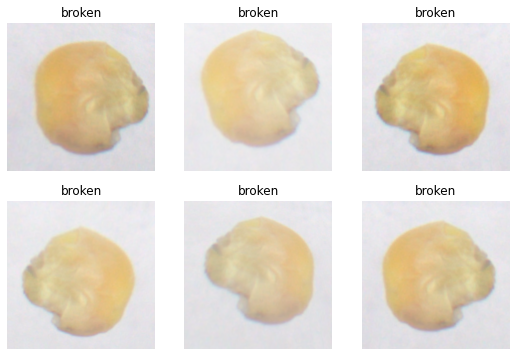

In [17]:
dls_default = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256)))

dls_default.show_batch(max_n=6, unique=True)

### Aggressive default transform
Let's again do the default transformation but slightly more aggressive (using mult=2).

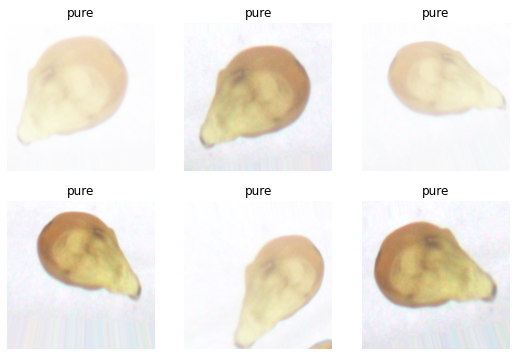

In [18]:
dls_mult2 = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256), mult=2.0))

dls_mult2.show_batch(max_n=6, unique=True)

### Do nothing transform
Let's try to do nothing in the transformation.  We could do this by setting 'batch_tfms=[]' but as you can see some transformations seem to take place anyways.  `dls_nothing` attempts to hand define parameters that should ask the transform to keep the image the same.  `dls_nothing_exaggerated` is the same as `dls_nothing` with `mult=100` to boost anything that wasn't manually set to do nothing (to help ensure that parameters were set properly).

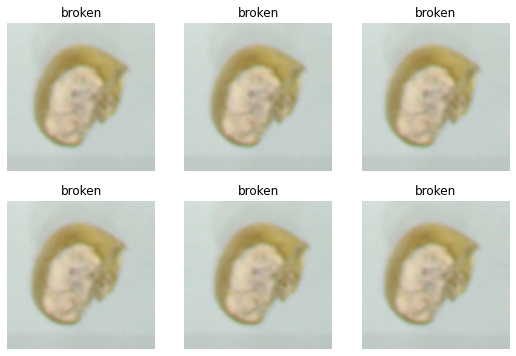

In [19]:
# set_seed(42)
dls_nothing_literal = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=[])

dls_nothing_literal.show_batch(max_n=6, unique=True)

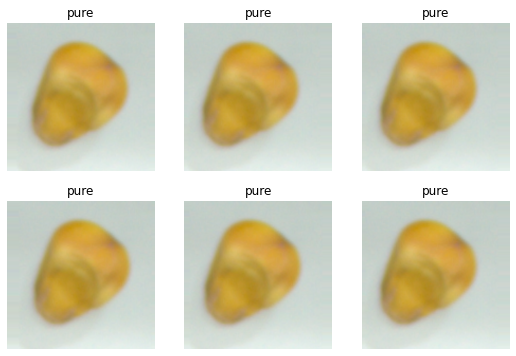

In [20]:
# set_seed(42)
dls_nothing_exaggerated = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,# seed=42,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(mult=100, size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=False, pad_mode='border'))#aug_transforms(size=(128,128), min_scale=1))

dls_nothing_exaggerated.show_batch(max_n=6, unique=True)

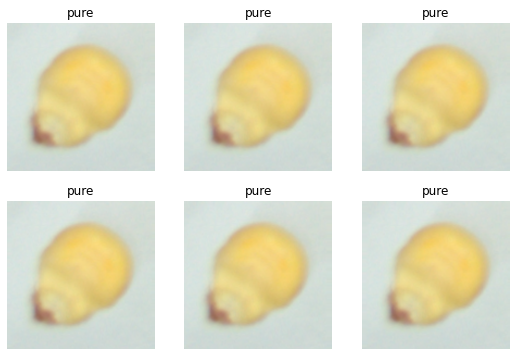

In [21]:
dls_nothing = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=False, pad_mode='border'))

dls_nothing.show_batch(max_n=6, unique=True)

### Flip only transformation

This will enable vertical and horizontal flipping only

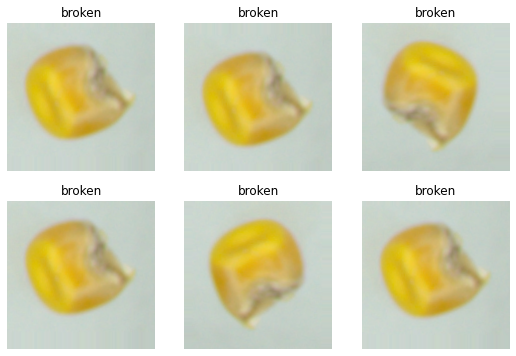

In [22]:
dls_flip = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=True, flip_vert=True, pad_mode='border'))

dls_flip.show_batch(max_n=6, unique=True)

### Rotate Only Transformation
Enable 360 degree rotation.

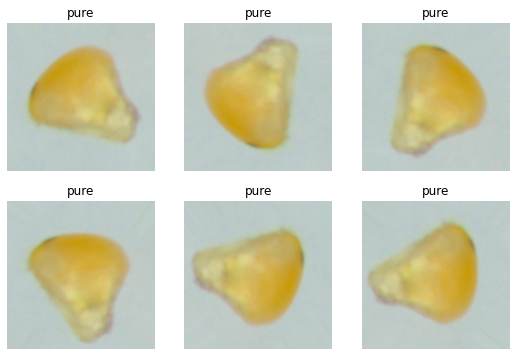

In [23]:
dls_rotate = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=360.0,
        do_flip=False, pad_mode='border'))

dls_rotate.show_batch(max_n=6, unique=True)

### Flip+Rotate Transformation
Enable vertical+horizontal flipping and 90 degree rotations

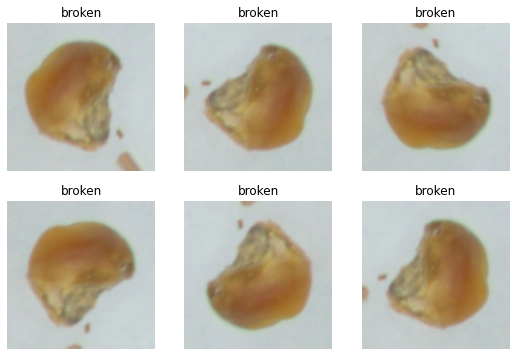

In [24]:
dls_flip_rotate = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'))

dls_flip_rotate.show_batch(max_n=6, unique=True)

### Default - Lighting Transformation
Start with `dls_default` and force lighting to be supressed.
- `max_lighting=0.0`
- `p_lighting=0.0`

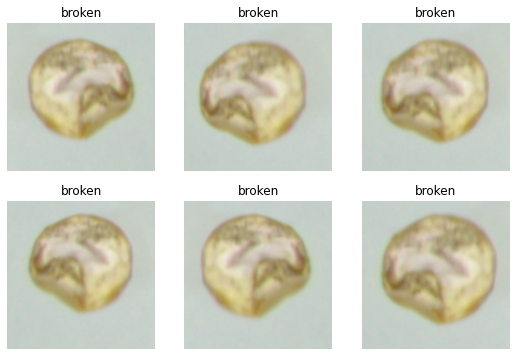

In [25]:
dls_default_nolight = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0))

dls_default_nolight.show_batch(max_n=6, unique=True)

### Default - Cropping Transformation
Start with `dls_default` and force cropping to be supressed.
- `min_scale=1.0`
- `min_zoom=1.0`
- `max_zoom=1.0`

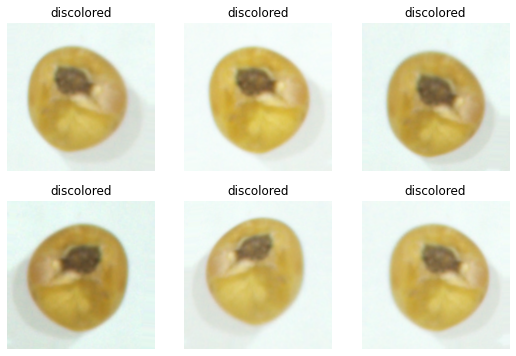

In [26]:
dls_default_nocrop = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0))

dls_default_nocrop.show_batch(max_n=6, unique=True)

## Default - Warping Transformation

Start with `dls_default` and force warping to be supressed.
- `max_warp=0.0`

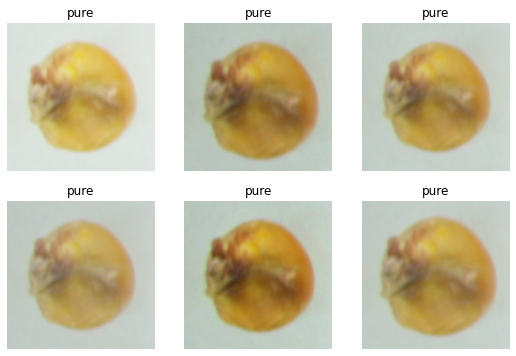

In [27]:
dls_default_nowarp = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        max_warp=0.0))

dls_default_nowarp.show_batch(max_n=6, unique=True)

### Default - Lighting + Cropping Transformation
Start with `dls_default` and force lighting and cropping to be supressed.
- `max_lighting=0.0`
- `p_lighting=0.0`
- `min_scale=1.0`
- `min_zoom=1.0`
- `max_zoom=1.0`

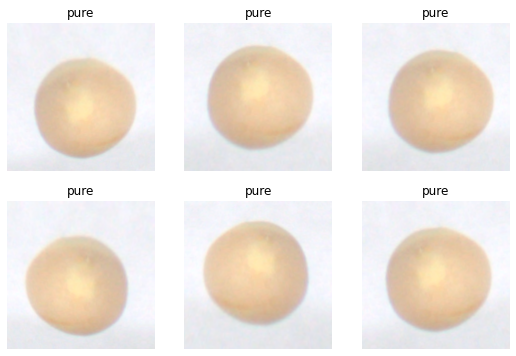

In [28]:
dls_default_nolightcrop = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0,
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0))

dls_default_nolightcrop.show_batch(max_n=6, unique=True)

### Default - Lighting + Cropping + Warping Transformation
Start with `dls_default` and force lighting, cropping and warping to be supressed.
- `max_lighting=0.0`
- `p_lighting=0.0`
- `min_scale=1.0`
- `min_zoom=1.0`
- `max_zoom=1.0`
- `max_warp=0.0`

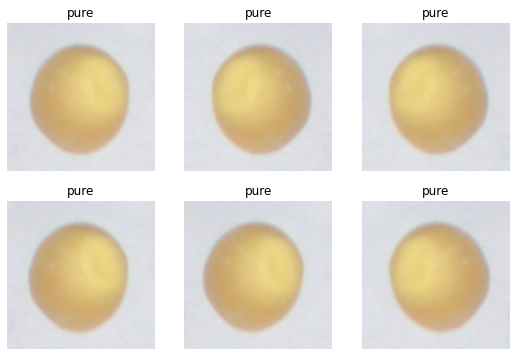

In [29]:
dls_default_nolightcropwarp = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0,
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_warp=0.0))

dls_default_nolightcropwarp.show_batch(max_n=6, unique=True)

### Flip + Rotate + Small Lighting Transformation
Starting from `dls_flip_rotate` and add some small lighting changes.
- `p_lighting=0.75`
- `max_lighting=0.1`

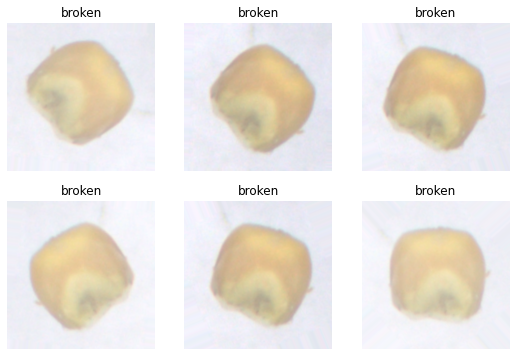

In [30]:
dls_flip_rotate_smlight = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'))

dls_flip_rotate_smlight.show_batch(max_n=6, unique=True)

### Flip + Rotate + Small Cropping Transformation
Starting from `dls_flip_rotate` and add some small cropping changes.
- `p_affine=0.75`
- `min_zoom=1.0`
- `max_zoom=1.2`

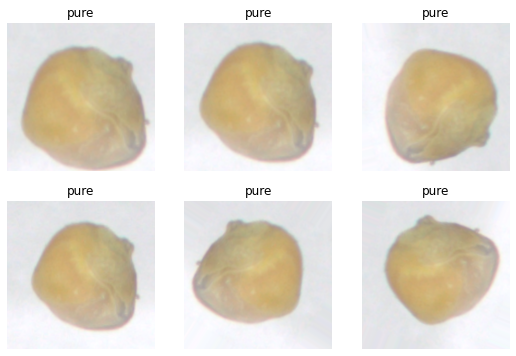

In [31]:
dls_flip_rotate_smcrop = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'))

dls_flip_rotate_smcrop.show_batch(max_n=6, unique=True)

### Flip + Rotate + Small Warping Transformation
Starting from `dls_flip_rotate` and add some small warping changes.
- `p_affine=0.75`
- `max_warp=0.2`

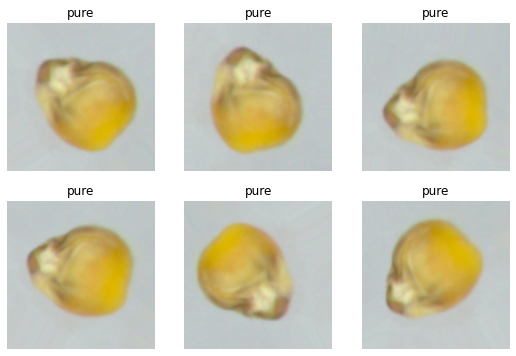

In [32]:
dls_flip_rotate_smwarp = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'))

dls_flip_rotate_smwarp.show_batch(max_n=6, unique=True)

### Flip + Rotate + Small Lighting + Cropping Transformation
Starting from `dls_flip_rotate` and add some small lighting and cropping changes.
- `p_lighting=0.75`
- `max_lighting=0.1`
- `p_affine=0.75`
- `min_zoom=1.0`
- `max_zoom=1.2`

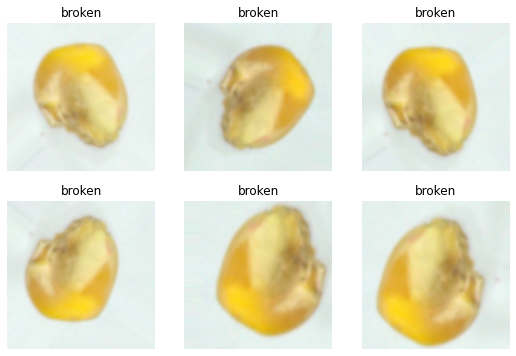

In [33]:
dls_flip_rotate_smlightcrop = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'))

dls_flip_rotate_smlightcrop.show_batch(max_n=6, unique=True)

### Flip + Rotate + Small Lighting + Cropping + Warping Transformation
Starting from `dls_flip_rotate` and add some small lighting, cropping and warping changes.
- `p_lighting=0.75`
- `max_lighting=0.1`
- `p_affine=0.75`
- `min_zoom=1.0`
- `max_zoom=1.2`
- `max_warp=0.2`

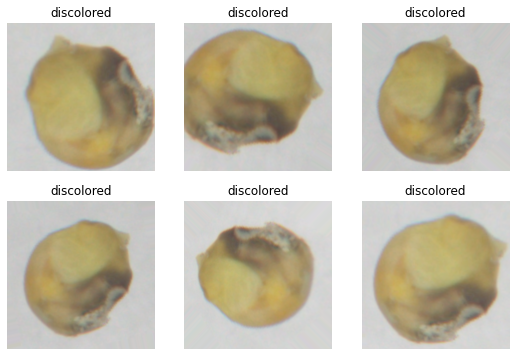

In [34]:
dls_flip_rotate_smlightcropwarp = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'))

dls_flip_rotate_smlightcropwarp.show_batch(max_n=6, unique=True)

### Play Transformation

Used this cell to just test some parameters when making the set of transformations above

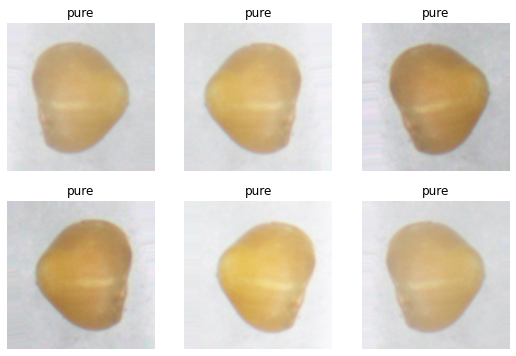

In [35]:
# set_seed(42)
dls = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Border),
    batch_tfms=aug_transforms(size=(256,256), min_scale=1.0,
        max_zoom=1.0, max_lighting=0.3, p_lighting=0.5,
        max_warp=0.0, p_affine=0.5, pad_mode='border'))#aug_transforms(size=(128,128), min_scale=1))

dls.show_batch(max_n=6, unique=True)

Let's make a dictionary of augmentations to use later.

dls_default

`batch_tfms=aug_transforms(size=(256,256))`

dls_mult2

`batch_tfms=aug_transforms(size=(256,256), mult=2.0)`

dls_nothing_literal

`batch_tfms=[]`

dls_nothing_exaggerated:

`batch_tfms=aug_transforms(mult=100, size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=False, pad_mode='border')`

dls_nothing:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=False, pad_mode='border')`

dls_flip:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=True, flip_vert=True, pad_mode='border')`

dls_rotate:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=360.0,
        do_flip=False, pad_mode='border')`

dls_flip_rotate:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border')`

dls_default_nolight:

`batch_tfms=aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0)`

dls_default_nocrop:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0)`
        
dls_default_nowarp:

`batch_tfms=aug_transforms(size=(256,256),
        max_warp=0.0)`

dls_default_nolightcrop:

`batch_tfms=aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0,
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0)`
        
dls_default_nolightcropwarp:

`batch_tfms=aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0,
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_warp=0.0)`

dls_flip_rotate_smlight:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border')`

dls_flip_rotate_smcrop:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border')`

dls_flip_rotate_smwarp:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border')`

dls_flip_rotate_smlightcrop:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border')`
        
dls_flip_rotate_smlightcropwarp:

`batch_tfms=aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border')`

In [36]:
augmentations = {
    'default': aug_transforms(size=(256,256)),
    'mult2': aug_transforms(size=(256,256), mult=2.0),
    'nothing': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=False, pad_mode='border'),
    'flip': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0,
        max_rotate=0.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'rotate': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=360.0,
        do_flip=False, pad_mode='border'),
    'flip_rotate': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'default_nolight': aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0),
    'default_nocrop': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0),
    'default_nowarp': aug_transforms(size=(256,256),
        max_warp=0.0),
    'default_nolightcrop': aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0,
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0),
    'default_nolightcropwarp': aug_transforms(size=(256,256),
        max_lighting=0.0, p_lighting=0.0,
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_warp=0.0),
    'flip_rotate_smlight': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smwarp': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcrop': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
}

augmentations_sub = {
    'default': aug_transforms(size=(256,256)),
    'flip_rotate': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcrop': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
}

## Model Experimentation

Let's experiment with some different architectures and image processing approaches (batch transforms).  In order to make this easier lets make a function that takes care of common modelling steps that we can hand different architectures, item transforms and batch transforms to:

In [37]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_csv(csv_path, 
        csv_fname='train.csv', valid_pct=0.2,
        seed=42, fn_col=2, label_col=3,
        item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch,
        metrics=[error_rate,accuracy]).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    learn.fine_tune(epochs, _slide)
    return learn

Let's try to re-run resnet26d to test

Path('kaggle-pog-series-s01e03/corn/models/resnet26d-test.pth')

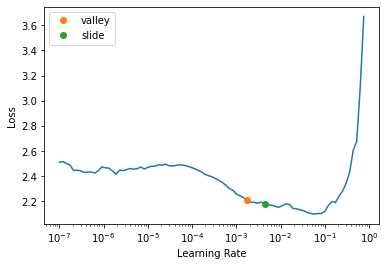

In [38]:
learn = train('resnet26d',
    item=Resize(128, method='squish'),
    batch=aug_transforms(size=128, min_scale=0.75),
    epochs=1)
learn.save('resnet26d-test')

testing: resnet26d-default-epochs_12


testing: resnet26d-mult2-epochs_12


testing: resnet26d-nothing-epochs_12


testing: resnet26d-flip-epochs_12


testing: resnet26d-rotate-epochs_12


testing: resnet26d-flip_rotate-epochs_12


testing: resnet26d-default_nolight-epochs_12


testing: resnet26d-default_nocrop-epochs_12


testing: resnet26d-default_nowarp-epochs_12


testing: resnet26d-default_nolightcrop-epochs_12


testing: resnet26d-default_nolightcropwarp-epochs_12


testing: resnet26d-flip_rotate_smlight-epochs_12


testing: resnet26d-flip_rotate_smcrop-epochs_12


testing: resnet26d-flip_rotate_smwarp-epochs_12


testing: resnet26d-flip_rotate_smlightcrop-epochs_12


testing: resnet26d-flip_rotate_smlightcropwarp-epochs_12


testing: convnext_small_in22k-default-epochs_12


testing: convnext_small_in22k-mult2-epochs_12


testing: convnext_small_in22k-nothing-epochs_12


testing: convnext_small_in22k-flip-epochs_12


testing: convnext_small_in22k-rotate-epochs_12


/home/speers/anaconda3/envs/fastai/lib/python3.9/site-packages/fastai/callback/schedule.py:272: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


testing: convnext_small_in22k-flip_rotate-epochs_12


testing: convnext_small_in22k-default_nolight-epochs_12


testing: convnext_small_in22k-default_nocrop-epochs_12


testing: convnext_small_in22k-default_nowarp-epochs_12


testing: convnext_small_in22k-default_nolightcrop-epochs_12


testing: convnext_small_in22k-default_nolightcropwarp-epochs_12


testing: convnext_small_in22k-flip_rotate_smlight-epochs_12


testing: convnext_small_in22k-flip_rotate_smcrop-epochs_12


testing: convnext_small_in22k-flip_rotate_smwarp-epochs_12


testing: convnext_small_in22k-flip_rotate_smlightcrop-epochs_12


testing: convnext_small_in22k-flip_rotate_smlightcropwarp-epochs_12


testing: convnext_large_in22k-default-epochs_12


testing: convnext_large_in22k-mult2-epochs_12


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 23.69 GiB total capacity; 20.93 GiB already allocated; 51.19 MiB free; 21.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

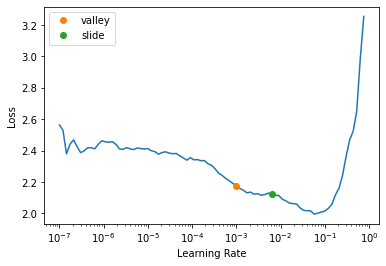

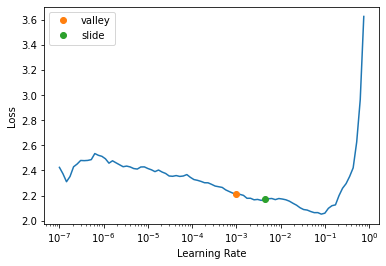

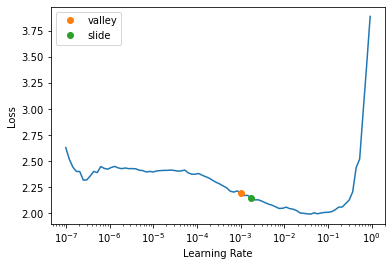

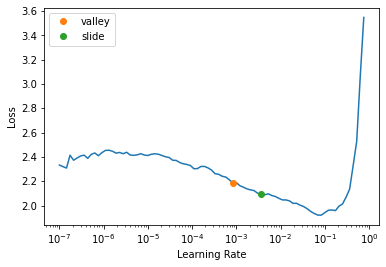

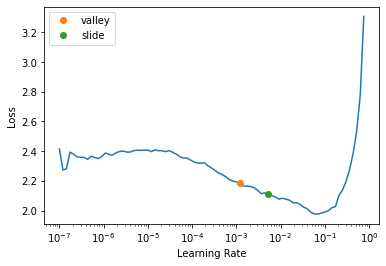

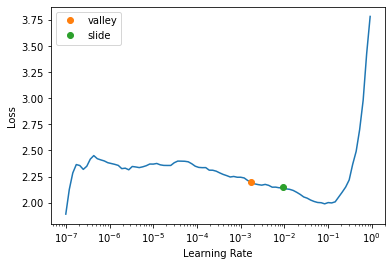

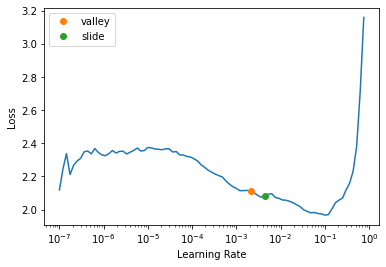

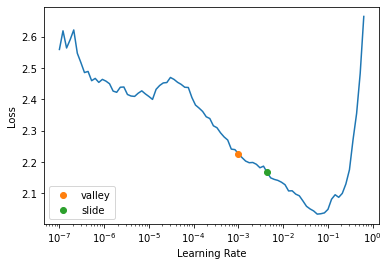

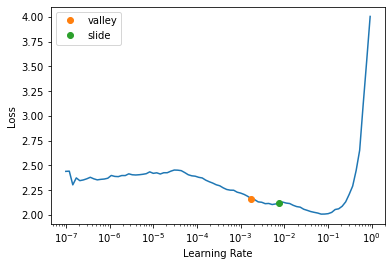

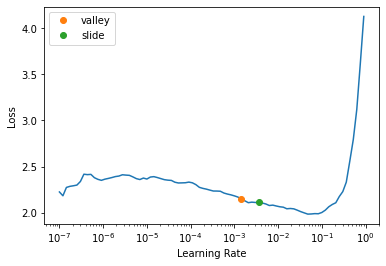

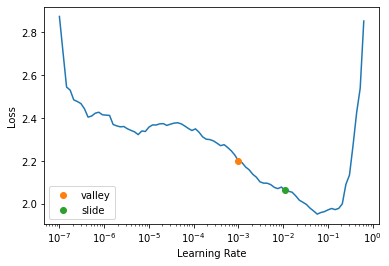

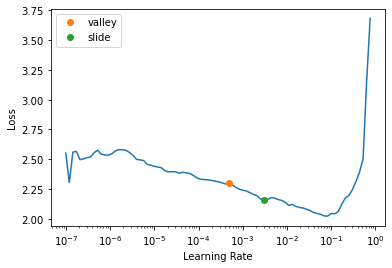

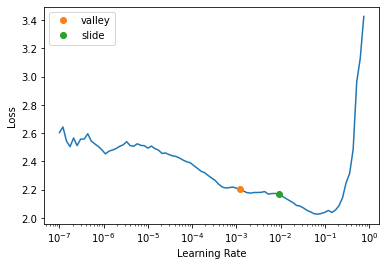

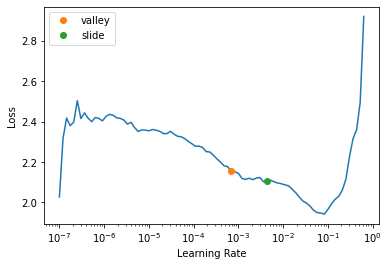

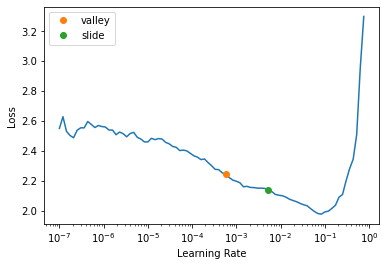

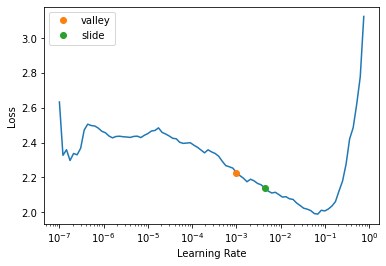

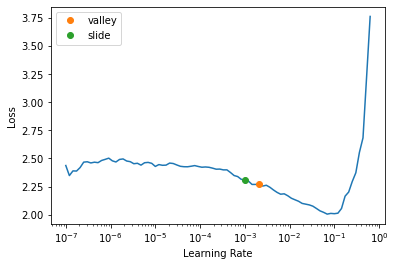

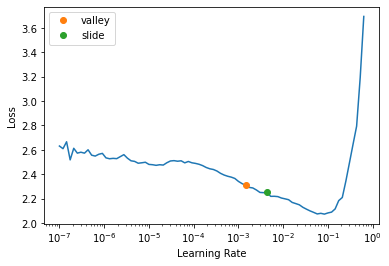

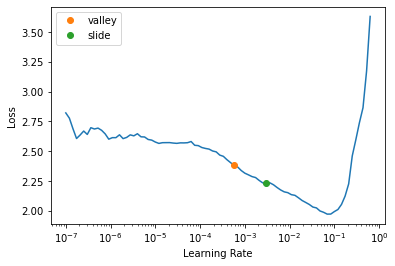

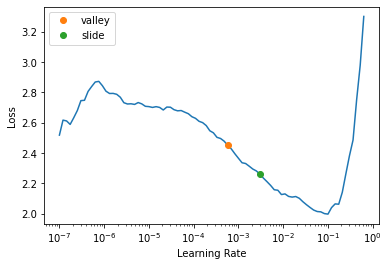

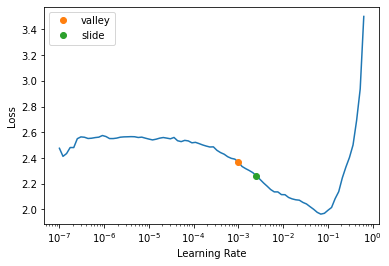

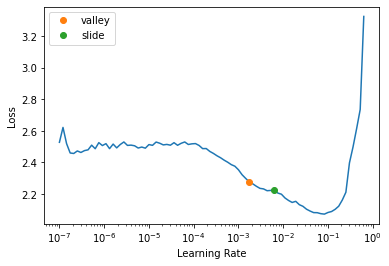

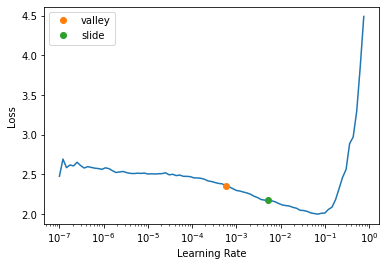

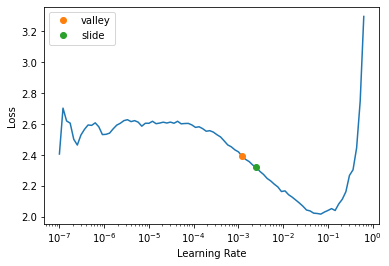

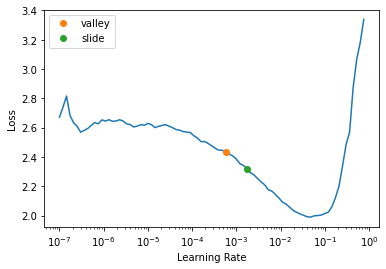

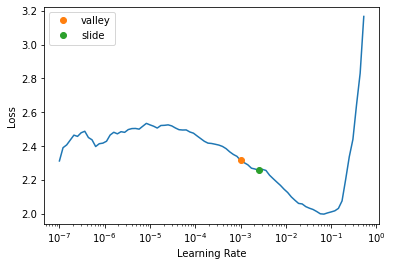

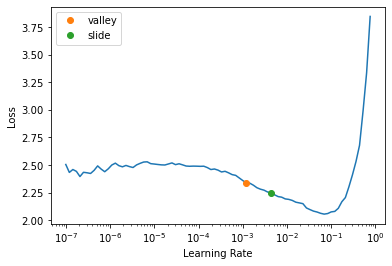

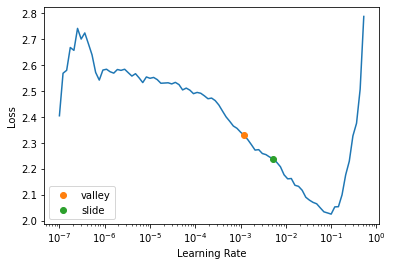

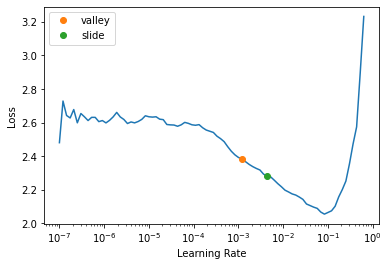

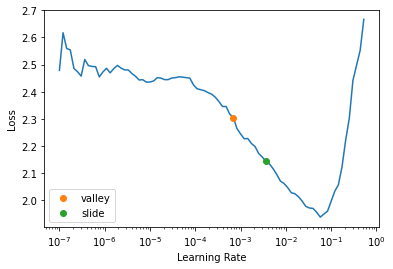

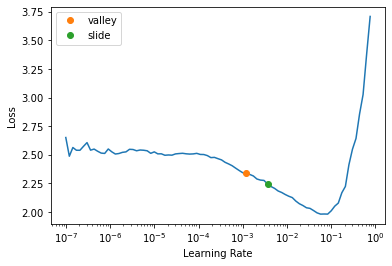

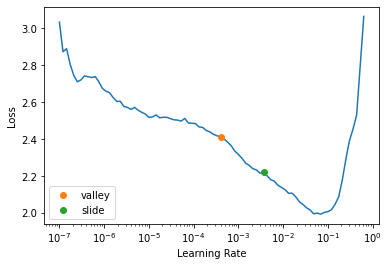

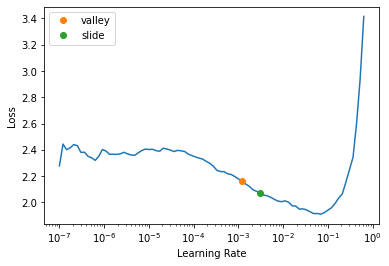

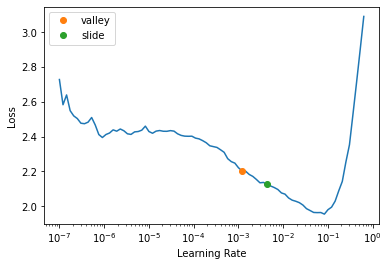

In [39]:
import gc

my_epochs = 12
models = ('resnet26d','convnext_small_in22k','convnext_large_in22k')
item_tfm = Resize((256,256), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)

for arch in models:
    for aug in augmentations:
        model_filename = f'{arch}-{aug}-epochs_{my_epochs}'
        print(f'testing: {model_filename}')
        aug_tfm = augmentations[aug]
        learn = train(arch,
            item=item_tfm,
            batch=aug_tfm,
            epochs=my_epochs)
        learn.save(model_filename)
        # Attempt to clear GPU memory (as best we can)
        gc.collect()
        torch.cuda.empty_cache()

## Results Table

Let's keep track of some of the results (should have saved these answers but will generate by hand as this took hours to run before crashing on the larger models -- why won't the memory clear properly).

|  Model  |  Augmentations | Val Loss Kept Decreasing? | Train Loss | Val Loss | Accuracy |
|---------|----------------|------------------|-----------|----------|----------|
| resnet26d | default | No | 0.281354 | 0.745106 | 0.755587 |
| resnet26d | mult2 | Yes- | 0.479232 | 0.641119 | 0.753492	|
| resnet26d | nothing | No | 0.242139 | 0.880888 | 0.708799	|
| resnet26d | flip | Yes- | 0.391578 | 0.702622	| 0.745810	|
| resnet26d | rotate | Yes- | 0.454006 | 0.608325 | 0.768855 |
| resnet26d | flip_rotate | Yes (not as stable) | 0.412753 | 0.595395 | 0.771997 |
| resnet26d | default_nolight | No | 0.317113 | 0.726981 | 0.748603 |
| resnet26d | default_nocrop | No | 0.338003 | 0.709788 | 0.739176 |
| resnet26d | default_nowarp | No++ | 0.187234 | 0.856788 | 0.746508 |
| resnet26d | default_nolightcrop | No+ | 0.348309 | 0.740403 | 0.739525 |
| resnet26d | default_nolightcropwarp | No++ | 0.102603 | 0.990288 | 0.755237 |
| resnet26d | flip_rotate_smlight | Yes | 0.512187 | 0.635557 | 0.748254 |
| resnet26d | flip_rotate_smcrop | Yes- | 0.416231 | 0.586482 | 0.779679 |
| resnet26d | flip_rotate_smwarp | Yes- | 0.488944 | 0.616912 | 0.757682 |
| resnet26d | flip_rotate_smlightcrop | Yes- | 0.465342 | 0.607168 | 0.769204 |
| resnet26d | flip_rotate_smlightcropwarp | Yes | 0.509245 | 0.614197 | 0.759427 |
| convnext_small_in22k | default | Yes | 0.427347 | 0.578864 | 0.773743 |
| convnext_small_in22k | mult2 | No | 0.285526 | 0.575667 | 0.793994 |
| convnext_small_in22k | nothing | No | 0.060242 | 0.928997 | 0.770251 |
| convnext_small_in22k | flip | No | 0.259672 | 0.583349 | 0.794344 |
| convnext_small_in22k | rotate | Yes | 0.376678 | 0.534201 | 0.797835 |
| convnext_small_in22k | flip_rotate | No | 0.291646 | 0.559900 | 0.799930 |
| convnext_small_in22k | default_nolight | No++ | 0.123955 | 0.748451 | 0.792947 |
| convnext_small_in22k | default_nocrop | No | 0.264373 | 0.583790 | 0.792598 |
| convnext_small_in22k | default_nowarp | Yes- | 0.291617 | 0.599893 | 0.778980 |
| convnext_small_in22k | default_nolightcrop | No | 0.248699 | 0.599541 | 0.790503 |
| convnext_small_in22k | default_nolightcropwarp | No | 0.101243 | 0.799259 | 0.780377 |
| convnext_small_in22k | flip_rotate_smlight | No | 0.313693 | 0.536456 | 0.796089 |
| convnext_small_in22k | flip_rotate_smcrop | Yes | 0.323615 | 0.528658 | 0.799232 |
| convnext_small_in22k | flip_rotate_smwarp | Yes (not as stable) | 0.346405 | 0.528210 | 0.797486 |
| convnext_small_in22k | flip_rotate_smlightcrop | Yes (not as stable) | 0.342636 | 0.529317 | 0.798883 |
| convnext_small_in22k | flip_rotate_smlightcropwarp | Yes- | 0.362320 | 0.534134 | 0.798184 |

Yes- -> indicates validation loss looks more stabilized
No + ++ -> indicates level of divergence in validation loss

## Aggregate Measures
|         Model        | Min Acc. | Max Acc. |    Average   |    StdDev.     |
|----------------------|----------|----------|--------------|----------------|
|        resnet26d     | 0.708799 | 0.779679 | 0.7529896875 | 0.01658086756  |
| convnext_small_in22k | 0.770251 | 0.799930 | 0.790961     | 0.009620508122 |

## Ranking by Accuracy (resnet26d)

Should have sorted next two tables in decreasing order (whoops) ... Best are at bottom!

| Model | Augmentations | Val Loss Kept Decreasing? | Train Loss | Val Loss | Accuracy |
|---|---|---|----|----|----|
| resnet26d | nothing | No | 0.242139 | 0.880888 | 0.708799 |
| resnet26d | default_nocrop | No | 0.338003 | 0.709788 | 0.739176 |
| resnet26d | default_nolightcrop | No+ | 0.348309 | 0.740403 | 0.739525 |
| resnet26d | flip | Yes- | 0.391578 | 0.702622 | 0.74581 |
| resnet26d | default_nowarp | No++ | 0.187234 | 0.856788 | 0.746508 |
| resnet26d | flip_rotate_smlight | Yes | 0.512187 | 0.635557 | 0.748254 | 
| resnet26d | default_nolight | No | 0.317113 | 0.726981 | 0.748603 |
| resnet26d | mult2 | Yes- | 0.479232 | 0.641119 | 0.753492 |
| resnet26d | default_nolightcropwarp | No++ | 0.102603 | 0.990288 | 0.755237 |
| resnet26d | default | No | 0.281354 | 0.745106 | 0.755587 |
| resnet26d | flip_rotate_smwarp | Yes- | 0.488944 | 0.616912 | 0.757682 |
| resnet26d | flip_rotate_smlightcropwarp | Yes | 0.509245 | 0.614197 | 0.759427 |
| resnet26d | rotate | Yes- | 0.454006 | 0.608325 | 0.768855 |
| resnet26d | flip_rotate_smlightcrop | Yes- | 0.465342 | 0.607168 | 0.769204 |
| resnet26d | flip_rotate | Yes (not as stable) | 0.412753 | 0.595395 | 0.771997 |
| resnet26d | flip_rotate_smcrop | Yes- | 0.416231 | 0.586482 | 0.779679 |


## Ranking By Accuracy (convnext_small_in22k)

| Model | Augmentations | Val Loss Kept Decreasing? | Train Loss | Val Loss | Accuracy |
|---|---|---|----|----|----|
| convnext_small_in22k | nothing | No | 0.060242 | 0.928997 | 0.770251 |
| convnext_small_in22k | default | Yes | 0.427347 | 0.578864 | 0.773743 |
| convnext_small_in22k | default_nowarp | Yes- | 0.291617 | 0.599893 | 0.77898 |
| convnext_small_in22k | default_nolightcropwarp | No | 0.101243 | 0.799259 | 0.780377 |
| convnext_small_in22k | default_nolightcrop | No | 0.248699 | 0.599541 | 0.790503 |
| convnext_small_in22k | default_nocrop | No | 0.264373 | 0.58379 | 0.792598 |
| convnext_small_in22k | default_nolight | No++ | 0.123955 | 0.748451 | 0.792947 |
| convnext_small_in22k | mult2 | No | 0.285526 | 0.575667 | 0.793994 |
| convnext_small_in22k | flip | No | 0.259672 | 0.583349 | 0.794344 |
| convnext_small_in22k | flip_rotate_smlight | No | 0.313693 | 0.536456 | 0.796089 |
| convnext_small_in22k | flip_rotate_smwarp | Yes (not as stable) | 0.346405 | 0.52821 | 0.797486 |
| convnext_small_in22k | rotate | Yes | 0.376678 | 0.534201 | 0.797835 |
| convnext_small_in22k | flip_rotate_smlightcropwarp | Yes- | 0.36232 | 0.534134 | 0.798184 |
| convnext_small_in22k | flip_rotate_smlightcrop | Yes (not as stable) | 0.342636 | 0.529317 | 0.798883 |
| convnext_small_in22k | flip_rotate_smcrop | Yes | 0.323615 | 0.528658 | 0.799232 |
| convnext_small_in22k | flip_rotate | No | 0.291646 | 0.5599 | 0.79993 |

General trends:
- default with subtraction augmentation methods by and large don't see continuously decreasing validation loss
- flip_rotate_smcrop was the best result in both of the smaller models where it val accuracy kept improving
- nothing performed worst in both cases
- default with subtraction methods were general poor performers and typically had issues with validation loss diverging
- rotate only (while simple) seemed to be a pretty good performer and had decreasing val loss
- flip_rotate with mods generally (with some exceptions) had top half accuracy and decreasing val loss.

Let's try some experiments with the following augmentation sets:
- flip_rotate_smcrop (worked best for small models)
- flip_rotate (simple, should be safe, rotate trained well on both, rotate/flip was best performer but had diverging training loss in convnext model)
- flip_rotate_smlightcropwarp (more aggressive augmentations, not best performer but might work better when moving to larger models)